In [1]:
import pystac_client
import planetary_computer
from pystac_client.stac_api_io import StacApiIO
from urllib3 import Retry

import geopandas as gpd
from odc.geo.geom import BoundingBox
import odc.geo.xr

import pandas as pd
import numpy as np
import xarray as xr
from odc.algo import mask_cleanup
from dea_tools.spatial import xr_rasterize

import requests
import xml.etree.ElementTree as ET
from collections import defaultdict

import odc.stac
from odc.stac import configure_rio
from datacube.utils.aws import configure_s3_access
from distributed import LocalCluster, Client

In [2]:
# Set up Dask Cluster for Parallelization
cluster = LocalCluster(n_workers=12, threads_per_worker=1, processes=False)
client = Client(cluster)
# configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)
configure_rio(cloud_defaults=True, client=client) # For Planetary Computer
print(client.dashboard_link)

http://155.207.39.39:8787/status


c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [3]:
def check_gri_refinement(items):
    refined_items = []
    refinement_data = []

    # Loop through items and extract `Image_Refining` flag
    for item in items:
        datastrip_metadata_url = None
        for asset_key, asset_data in items[0].assets.items():
            if "datastrip-metadata" in asset_key.lower(): # and asset_data.href.endswith(".xml"):
                # datastrip_metadata_url = planetary_computer.sign(asset_data.href)
                datastrip_metadata_url = asset_data.href
                break

        if datastrip_metadata_url:
            # print(f"Processing: {datastrip_metadata_url}")
            print(f"Processing: {item.id}") #print(f"Processing: {datastrip_metadata_url}")

            # Fetch XML content
            xml_response = requests.get(datastrip_metadata_url)
            if xml_response.status_code == 200:
                root = ET.fromstring(xml_response.content)

                # Extract Image_Refining flag
                refining_element = root.find(".//Geometric_Info/Image_Refining")
                refining_flag = refining_element.get("flag") if refining_element is not None else "Not Found"

                print(f"Image Refining Flag: {refining_flag}")

                # Store item and status in dataframe
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": refining_flag
                })

                # Append to refined_items if the flag is 'REFINED'
                if refining_flag == "REFINED":
                    refined_items.append(item)
            else:
                # print(f"Failed to fetch XML: {xml_response.status_code}")
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": "Fetch Failed"
                })
        else:
            # print("datastrip_metadata.xml not found in STAC item")
            refinement_data.append({
                "item_id": item.id,
                "refinement_status": "Metadata Not Found"
            })

    # Create a DataFrame
    df_refinement_status = pd.DataFrame(refinement_data)

    return refined_items, df_refinement_status


In [21]:
aoi = gpd.read_file('../anciliary/grid_v2.geojson').to_crs('EPSG:4326')
# Get the bounds of the 9th geometry
minx, miny, maxx, maxy = aoi.iloc[7].geometry.bounds
print(aoi.iloc[7].tile_ids)
aoi_bbox = BoundingBox.from_xy(
    (minx, maxx),
    (miny, maxy)
)

x06_y10


In [5]:
aoi.explore()

In [6]:
aoi_bbox.explore()

**SR#1: P01/P02. Limited Sentinel-2 Data Availability due to Cloud Cover**

This issue could arise if there are not enough images to generate monthly mosaics-especially due to winter season.
- Mitigation Measures: Develop bi-monthly image composites using Sentinel-2 imagery.
    - Back-up Measures: If bimonthly composites also fail, we will explore integrating Landsat imagery in the process or generating cloud free subsets within each AOI.


In [7]:
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime='2024-07',
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)

items = search.item_collection()
print(f'Found {len(items)} items')

Found 5 items


In [8]:
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime='2024-01-01/2024-02-29',
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)

items = search.item_collection()
print(f'Found {len(items)} items')
print(f'Searching for GRI REFINED scenes...')
print(f'###################################')
# Regarding mis-registration (as observed in 2023 vs 2024):
# See: https://forum.step.esa.int/t/geometric-gri-refinement-in-sentinel-2-level-1c-early-images-below-pb-3-0/44024/2
# Finally, the activation of the geometric refining does not mean that the products will be always refined. 
# There are some cases (e.g. too many clouds) where the refining cannot be applied as it would not improve 
# and could degrade the geolocation of the products. This can be checked thanks to the metadata 
# Image_Data_Info/Geometric_Info/Image_Refining in the datastrip matadata file (DATASTRIP/*/MTD_DS.xml). In STAC: datastrip_metadata
# This parameter is equal to REFINED or NOT_REFINED.
#<Geometric_Info metadataLevel="Standard">
#   <RGM>COMPUTED</RGM>
#   <Image_Refining flag="REFINED">
refined_items, df_refinement_status = check_gri_refinement(items)

Found 7 items
Searching for GRI REFINED scenes...
###################################
Processing: S2B_MSIL2A_20240220T093029_R136_T34SDH_20240220T121733
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240215T093101_R136_T34SDH_20240215T141952
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240205T093201_R136_T34SDH_20240205T154053
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240131T093129_R136_T34SDH_20240131T131805
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240126T093251_R136_T34SDH_20240126T142122
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240116T093331_R136_T34SDH_20240116T142521
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240101T093319_R136_T34SDH_20240101T121856
Image Refining Flag: REFINED


In [9]:
items = refined_items

if len(items) == 0:        
    msg = f"Search returned 0 Items for `cloud cover`={cloud_cover}. Terminating this composite generation."
    print(msg)
    raise ValueError(msg)
else:
    filtered_items = []
    tiles = np.unique([i.properties['s2:mgrs_tile'] for i in items])
    epsgs = np.unique([i.properties['proj:epsg'] for i in items])
    
    for tile in tiles:
        item_mgrs_sorted = sorted([i for i in items if i.properties['s2:mgrs_tile'] == str(tile)], key=lambda item: item.properties['eo:cloud_cover'])
        if len(item_mgrs_sorted) > 10:
            filtered_items.extend(item_mgrs_sorted[:10])
        else:
            filtered_items.extend(item_mgrs_sorted)
    print(f"Filtered cleanest scenes: Kept {len(filtered_items)} out of {len(items)} items. ")
    print(f"Tiles: {tiles}")
    print(f"EPSG: {epsgs[0]}")
    items = filtered_items
    display(items)

Filtered cleanest scenes: Kept 7 out of 7 items. 
Tiles: ['34SDH']
EPSG: 32634


[<Item id=S2A_MSIL2A_20240215T093101_R136_T34SDH_20240215T141952>,
 <Item id=S2B_MSIL2A_20240131T093129_R136_T34SDH_20240131T131805>,
 <Item id=S2A_MSIL2A_20240126T093251_R136_T34SDH_20240126T142122>,
 <Item id=S2A_MSIL2A_20240205T093201_R136_T34SDH_20240205T154053>,
 <Item id=S2B_MSIL2A_20240220T093029_R136_T34SDH_20240220T121733>,
 <Item id=S2A_MSIL2A_20240116T093331_R136_T34SDH_20240116T142521>,
 <Item id=S2B_MSIL2A_20240101T093319_R136_T34SDH_20240101T121856>]

In [10]:
ds_cube = odc.stac.stac_load(
        items,
        bbox=aoi_bbox,
        # bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'SCL'],
        bands=['B02', 'B03', 'B04', 'B8A', 'SCL'],
        chunks=dict(y=1024, x=1024),
        # crs=f'epsg:{epsgs[0]}', # Equi7Grid European EPSG (https://github.com/TUW-GEO/Equi7Grid)
        crs=f'epsg:3035',
        resolution=20,
        groupby='time', # if 'time' loads all items, retaining duplicates
        fail_on_error=True,
        resampling={
            "*": "cubic",
        },
    )
ds_cube

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 3063, x: 2995, time: 7)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
  * time         (time) datetime64[ns] 56B 2024-01-01T09:33:19.024000 ... 202...
Data variables:
    B02          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL          (time, y, x) float32 257MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [11]:
# - 0: no data
# - 1: saturated or defective
# - 2: dark area pixels
# - 3: cloud shadows
# - 4: vegetation
# - 5: bare soils
# - 6: water
# - 7: unclassified
# - 8: cloud medium probability
# - 9: cloud high probability
# - 10: thin cirrus
# - 11: snow or ice
invalid_scl_values = [3, 7, 8, 9, 10, 11]
cloud_binary_mask = ds_cube.SCL.isin(invalid_scl_values)

# bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
bands=['B02', 'B03', 'B04', 'B8A']
ds_cube_cf = ds_cube[bands].where(~cloud_binary_mask, 0).astype('uint16')
ds_cube_cf

<xarray.Dataset> Size: 514MB
Dimensions:      (time: 7, y: 3063, x: 2995)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
  * time         (time) datetime64[ns] 56B 2024-01-01T09:33:19.024000 ... 202...
Data variables:
    B02          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) uint16 128MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [12]:
ds_cube_cf = ds_cube_cf.where(ds_cube_cf > 0, np.nan)
median_composite = ds_cube_cf[bands].median(dim='time').astype('float32').compute()
median_composite

<xarray.Dataset> Size: 147MB
Dimensions:      (y: 3063, x: 2995)
Coordinates:
  * y            (y) float64 25kB 1.783e+06 1.783e+06 ... 1.721e+06 1.721e+06
  * x            (x) float64 24kB 5.226e+06 5.226e+06 ... 5.286e+06 5.286e+06
    spatial_ref  int32 4B 3035
Data variables:
    B02          (y, x) float32 37MB 1.219e+03 1.222e+03 ... 1.225e+03 1.208e+03
    B03          (y, x) float32 37MB 1.101e+03 1.103e+03 ... 1.13e+03 1.117e+03
    B04          (y, x) float32 37MB 1.044e+03 1.047e+03 ... 1.07e+03 1.065e+03
    B8A          (y, x) float32 37MB 1.013e+03 1.02e+03 ... 1.036e+03 1.039e+03

In [13]:
import rioxarray as rxr

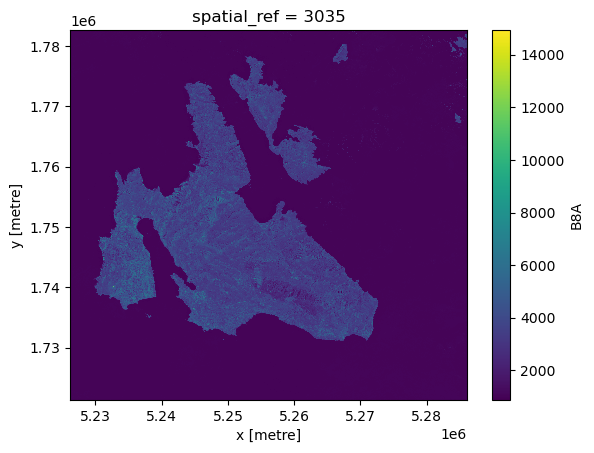

In [14]:
median_composite.B8A.plot()

In [43]:
NASROOT='//nas-rs.topo.auth.gr/Latomeia/DROUGHT'
FOLDER='TEST_COMPO/x06_y10_2024'
DATASET= 'test_x06_y10_2024'
PRODUCT_NAME = 'test'
collection_path = f"{NASROOT}/{FOLDER}"
eo3_path = f'{collection_path}/{DATASET}.odc-metadata.yaml'
stac_path = f'{collection_path}/{DATASET}.stac-metadata.json'
datetime_list = [
    ds_cube_cf.isel(time=0).time.dt.year.item(),
    ds_cube_cf.isel(time=0).time.dt.month.item(),
    1
]

In [ ]:
median_composite = median_composite.rename({
    "B02": "blue",
    "B03": "green",
    "B04": "red",
    "B8A": "nir"
})
bands = ['blue', '']

In [67]:
name_measurements = []
for var in list(median_composite.data_vars):
    print(var)
    median_composite[var] = median_composite[var].astype('int16')
    median_composite[var].attrs['nodata'] = 0
    
    file_path = f'{collection_path}/{DATASET}_{var}.tif'
    
    median_composite[var].rio.to_raster(raster_path=file_path, 
                                       driver='COG',
                                       dtype='uint16',
                                       windowed=True,
                                       )
    name_measurements.append(file_path)

blue
green
red
nir


In [68]:
name_measurements

['//nas-rs.topo.auth.gr/Latomeia/DROUGHT/TEST_COMPO/x06_y10_2024/test_x06_y10_2024_blue.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/TEST_COMPO/x06_y10_2024/test_x06_y10_2024_green.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/TEST_COMPO/x06_y10_2024/test_x06_y10_2024_red.tif',
 '//nas-rs.topo.auth.gr/Latomeia/DROUGHT/TEST_COMPO/x06_y10_2024/test_x06_y10_2024_nir.tif']

In [69]:
yyyy = ds_cube_cf.isel(time=0).time.dt.year.item()
mm1 = ds_cube_cf.isel(time=0).time.dt.month.item()
mm2 = ds_cube_cf.isel(time=-1).time.dt.month.item()
dd1 = ds_cube_cf.isel(time=0).time.dt.day.item()
dd2 = ds_cube_cf.isel(time=-1).time.dt.day.item()
median_composite.attrs['dtr:start_datetime']=f'{yyyy}-{mm1:02d}-{dd1:02d}'
median_composite.attrs['dtr:end_datetime']=f'{yyyy}-{mm2:02d}-{dd2:02d}'
median_composite.attrs['odc:region_code']=aoi.iloc[7].tile_ids

In [70]:
import rasterio as rio
from eodatasets3 import DatasetPrepare, DatasetDoc, ValidDataMethod
from eodatasets3.model import ProductDoc, AccessoryDoc
from eodatasets3 import serialise
from eodatasets3.stac import to_stac_item

from shapely import Polygon

import datetime
import pandas as pd
from pathlib import Path

In [18]:
import datacube
dc = datacube.Datacube(app='test', env='drought')

In [86]:
nas_root=NASROOT
set_range=True
lineage_path=False
version=1
product_family='ard'
product_name=PRODUCT_NAME
dataset_name=DATASET
xr_cube = median_composite.copy()

y,m,d = datetime_list

with DatasetPrepare(
    dataset_location=Path(collection_path),                 #  A string location is expected to be a URL or VSI path.
    metadata_path=Path(f'{collection_path}/{dataset_name}.odc-metadata.yaml'), #  A string location is expected to be a URL or VSI path.
    allow_absolute_paths=False,
    naming_conventions="default"
) as preparer:

    preparer.valid_data_method = ValidDataMethod.bounds

    preparer.product_name = product_name
    preparer.product_family = product_family
    preparer.product_maturity = "stable"
    preparer.dataset_version = str(version) # if used without product_name then 'product': {'name': 'productname_1'}

    preparer.datetime = datetime.datetime(y,m,d)
    if set_range:
        preparer.datetime_range = [
            datetime.datetime(int(xr_cube.attrs['dtr:start_datetime'][0:4]),
                              int(xr_cube.attrs['dtr:start_datetime'][5:7]),
                              int(xr_cube.attrs['dtr:start_datetime'][8:10]),
                              0,0,0),
            datetime.datetime(int(xr_cube.attrs['dtr:end_datetime'][0:4]),
                              int(xr_cube.attrs['dtr:end_datetime'][5:7]),
                              int(xr_cube.attrs['dtr:end_datetime'][8:10]),
                              23,59,59)]
    preparer.processed_now()

    preparer.properties["odc:region_code"] = xr_cube.attrs['odc:region_code']
    preparer.properties["odc:file_format"] = "GeoTIFF"
    preparer.properties["odc:processing_datetime"] = datetime.datetime.now().isoformat()

    if hasattr(xr_cube, 'eo:instrument"'):
        preparer.properties["eo:instrument"] = xr_cube.attrs['eo:instrument']
    if hasattr(xr_cube, 'eo:platform"'):
        preparer.properties["eo:platform"] = xr_cube.attrs['eo:platform']
    preparer.properties["eo:gsd"] = int(abs(xr_cube.odc.geobox.resolution.x))


    if lineage_path:
        preparer.add_accessory_file("lineage", lineage_path) # For composites, path to json with S2 IDs

    # if uuid_lineage:
    #     preparer.note_source_datasets(product_lineage, uuid_lineage) # As in ("ard", metadata["id"]), UUIDs from datacube schema

    polygon_geometry = Polygon(xr_cube.odc.geobox.boundingbox.polygon.boundary.coords)
    preparer.geometry = polygon_geometry

    bands = list(dc.list_measurements().loc[product_name].name.values)
    for name, path in zip(bands, name_measurements):
        preparer.note_measurement(name, str(Path(path).resolve()), relative_to_dataset_location=False) # else: (name, f'{granule_dir}/{path}', relative_to_dataset_location=False)

    eo3_doc = preparer.to_dataset_doc()

    crs, grid_docs, measurement_docs = preparer._measurements.as_geo_docs()

    eo3 = DatasetDoc(
        id=preparer.dataset_id,
        label=preparer.label,
        product=ProductDoc(
            name=preparer.names.product_name, href=preparer.names.product_uri
        ),
        crs=preparer._crs_str(crs) if crs is not None else None,
        geometry=polygon_geometry,
        grids=grid_docs,
        properties=preparer.properties,
        accessories={
            name: AccessoryDoc(path, name=name)
            for name, path in preparer._accessories.items()
        },
        measurements=measurement_docs,
        # lineage=preparer._lineage, # Preparer does not have _lineage
    )

    for measurement in eo3.measurements.values():
        if measurement.grid is None:
            measurement.grid = 'default'

stac_path = f'{collection_path}/{dataset_name}.stac-metadata.json'
stac_doc = to_stac_item(dataset=eo3, stac_item_destination_url=stac_path, collection_url=f'file://{collection_path}')


In [87]:
import json
serialise.to_path(Path(eo3_path), eo3_doc)
with open(stac_path, 'w') as json_file:
    json.dump(stac_doc, json_file, indent=4, default=False)

In [91]:
from datacube.index.hl import Doc2Dataset
WORKING_ON_CLOUD=False
uri = eo3_path if WORKING_ON_CLOUD else f"file:///{eo3_path}"

resolver = Doc2Dataset(dc.index)
dataset_tobe_indexed, err  = resolver(doc_in=serialise.to_doc(eo3_doc), uri=uri)

In [92]:
err

In [93]:
dc.index.datasets.add(dataset=dataset_tobe_indexed, with_lineage=False)

Dataset <id=7d9be04e-fb4d-4ed5-8137-bf53724a6252 product=test location=file://///nas-rs.topo.auth.gr/Latomeia/DROUGHT/TEST_COMPO/x06_y10_2024/test_x06_y10_2024.odc-metadata.yaml>

# Test loading

In [95]:
new = dc.load(
    product='test',
    
)

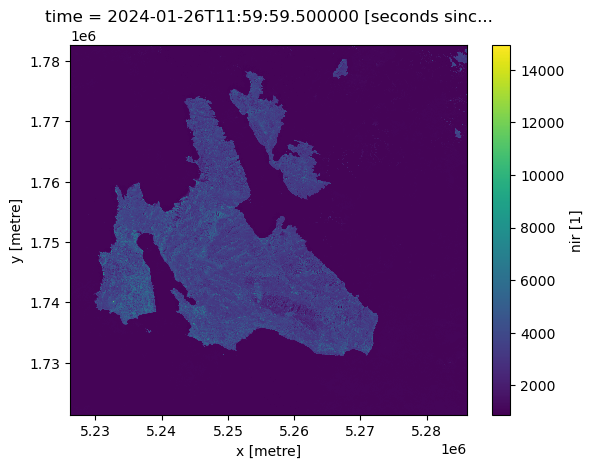

In [97]:
new.nir.plot()